# <i><center>Comparación de datos de Precipitación del Senamhi y el producto Pisco</center></i>
---
Author: [**@JorgeCruz**](https://www.kaggle.com/jorgeluiscruzquispe)

### <i>Fuente de datos</i>

- Producto grillado pisco: https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/.Prec/.v1p0_O/
- Estaciones publimetricas del senamhi: https://www.senamhi.gob.pe/site/descarga-datos/
- Estaciones hidrometeorologicas shapefile: https://www.geogpsperu.com/2018/07/mapa-de-estaciones-hidrometeorologicas.html

### Area de estudio
- Cuenca Rímac, Lima, Perú

### Resumen
> El codigo tiene la finalidad de de comparar los datos de una estación pluviometrica con los datos del producto grillado Pisco, luego de habe realizado la automatización de las estaciones pluviometrica, se identifica que estaciones tienen los valores más cercanos a el producto Pisco teniendo en consideración tres metricas. Al finalizar esta completación se realizá un selección de las estaciones que tienen datos más cercanos y se procede a realizar la completación de los datos faltantes que tiene los datos de precipitación de la estación pluviometrica (si es que tiene faltantes)


<span style="color: red">Los datos con que se trabajan son diarios</span>

In [1]:
!pip install -q hydroeval

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import pandas as pd
import xarray as xr
import numpy as np
import hydroeval
import glob
import os

In [3]:
!wget https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/.Prec/.v2p1/.stable/.daily/.Prec/data.nc
os.rename("data.nc", "pp_daily.nc")

--2024-06-22 03:14:45--  https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/.Prec/.v2p1/.stable/.daily/.Prec/data.nc
Resolving iridl.ldeo.columbia.edu (iridl.ldeo.columbia.edu)... 129.236.110.35
Connecting to iridl.ldeo.columbia.edu (iridl.ldeo.columbia.edu)|129.236.110.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1385118160 (1.3G) [application/x-netcdf]
Saving to: 'data.nc'

data.nc             100%[===================>]   1.29G  12.4MB/s    in 1m 49s  

2024-06-22 03:16:35 (12.1 MB/s) - 'data.nc' saved [1385118160/1385118160]



# Funciones

In [4]:
 def nc_to_df(data, longitud, latitud):
        
    info = xr.load_dataset(data, decode_times = False)

    info = info.assign_coords(T = pd.date_range("1981-01-01", periods = len(info.T.data), freq = "d").strftime('%Y-%m-%d'))

    pp = info.sel(X = longitud, Y = latitud, method = "nearest")

    return pd.DataFrame(data = pp.Prec.data, index = pd.to_datetime(pp.T.data), columns = ["precipitation"])

def txt_to_df(list_):

    test = pd.read_csv(list_, sep = " ", header = None, 
                       names = ["year", "month", "day", "precipitation", "temp_max", "temp_min"])

    test["date"] = pd.to_datetime(test[['year', 'month', 'day']])

    test.set_index("date", inplace = True)

    test = test["precipitation"].to_frame()

    test.replace(-99.9, np.nan, inplace=True)

    return test

def metrics(estaciones_nom):
    
    list_pbias = []
    
    list_nse = []
    
    list_rmse = []
    
    list_rango = []
    
    list_faltante = []
    
    for i in range(len(estaciones_nom)):

        df_pisco = nc_to_df("pp_daily.nc", longitud[i], latitud[i])

        df_senamhi = txt_to_df(list_pp[i])

        range_min = max(df_pisco.index.min(), df_senamhi.index.min())

        range_max = min(df_pisco.index.max(), df_senamhi.index.max())

        pisco = df_pisco[range_min: range_max]

        senamhi = df_senamhi[range_min: range_max]
        
        pbias = hydroeval.evaluator(hydroeval.pbias, pisco.precipitation, senamhi.precipitation)[0]
        
        nse = hydroeval.evaluator(hydroeval.nse, pisco.precipitation, senamhi.precipitation)[0]
        
        rmse = hydroeval.evaluator(hydroeval.rmse, pisco.precipitation, senamhi.precipitation)[0]
        
        list_pbias.append(pbias)

        list_nse.append(nse)

        list_rmse.append(rmse)
        
        list_rango.append(len(pisco))
        
        list_faltante.append(round(100*senamhi.isna().sum().sum()/len(pisco), 2))
    
    df = pd.DataFrame({
        "c.datos": list_rango,
        "%faltante": list_faltante,
        "pbias": list_pbias,
        "nse": list_nse,
        "rmse": list_rmse,
    }, index = estaciones_nom)
    
    return df

def fill_station(*estaciones_comp):
    
    df = pd.DataFrame()
    
    for esta_comp in estaciones_comp:
    
        for i, col in enumerate(estaciones_nom):
           
            if esta_comp == col: 
                
                df_pisco = nc_to_df("pp_daily.nc", longitud[i], latitud[i])

                df_senamhi = txt_to_df(list_pp[i])

                range_min = max(df_pisco.index.min(), df_senamhi.index.min())

                range_max = min(df_pisco.index.max(), df_senamhi.index.max())

                pisco = df_pisco[range_min: range_max]

                senamhi = df_senamhi[range_min: range_max]
                
                df_comp = senamhi.fillna(pisco)
                
                df[esta_comp] = df_comp
        
    return df

# Procesamiento de datos

In [5]:
path_flood = '/kaggle/input/rimac-estaciones/'

names_flood = glob.glob('*.txt', dir_fd = path_flood)

list_pp = [path_flood + i for i in names_flood]

list_pp

['/kaggle/input/rimac-estaciones/qc00151210.txt',
 '/kaggle/input/rimac-estaciones/qc00155223.txt',
 '/kaggle/input/rimac-estaciones/qc00155122.txt',
 '/kaggle/input/rimac-estaciones/qc00155213.txt',
 '/kaggle/input/rimac-estaciones/qc00151205.txt',
 '/kaggle/input/rimac-estaciones/qc00155224.txt',
 '/kaggle/input/rimac-estaciones/qc00000548.txt',
 '/kaggle/input/rimac-estaciones/qc00151209.txt',
 '/kaggle/input/rimac-estaciones/qc00000543.txt',
 '/kaggle/input/rimac-estaciones/qc00151213.txt']

In [6]:
codigos = [i[4:10] for i in names_flood]
codigos.sort()

In [7]:
codigos

['000543',
 '000548',
 '151205',
 '151209',
 '151210',
 '151213',
 '155122',
 '155213',
 '155223',
 '155224']

In [8]:
estaciones_hidromet = gpd.read_file(
    "/kaggle/input/estaciones-hidromet/estaciones hidrometeorologicas ana senamhi geogpsperu.shp", crs = 32718)

estaciones_codigo = estaciones_hidromet[estaciones_hidromet.CODIGO.isin(codigos)].copy()

estaciones_codigo.to_crs(4326, inplace = True)

estaciones_codigo = estaciones_codigo.sort_values(by = ['CODIGO'])

In [9]:
estaciones_codigo.CODIGO.tolist()

['000543',
 '000548',
 '151205',
 '151209',
 '151210',
 '151213',
 '155122',
 '155213',
 '155223',
 '155224']

In [10]:
estaciones_nom = estaciones_codigo.Nombre.tolist()
estaciones_nom

['ANA',
 'MATUCANA',
 'CANCHACALLA',
 'CHOSICA',
 'RIO BLANCO',
 'SHEQUE',
 'AUTISHA',
 'SANTA EULALIA',
 'CARAMPOMA',
 'SANTIAGO DE TUNA']

In [11]:
longitud =  estaciones_codigo.bounds.minx.tolist()

latitud = estaciones_codigo.bounds.miny.tolist()

# Graficos

In [12]:
estaciones_codigo.explore("Nombre", tiles = "CartoDB dark_matter", cmap = "jet")

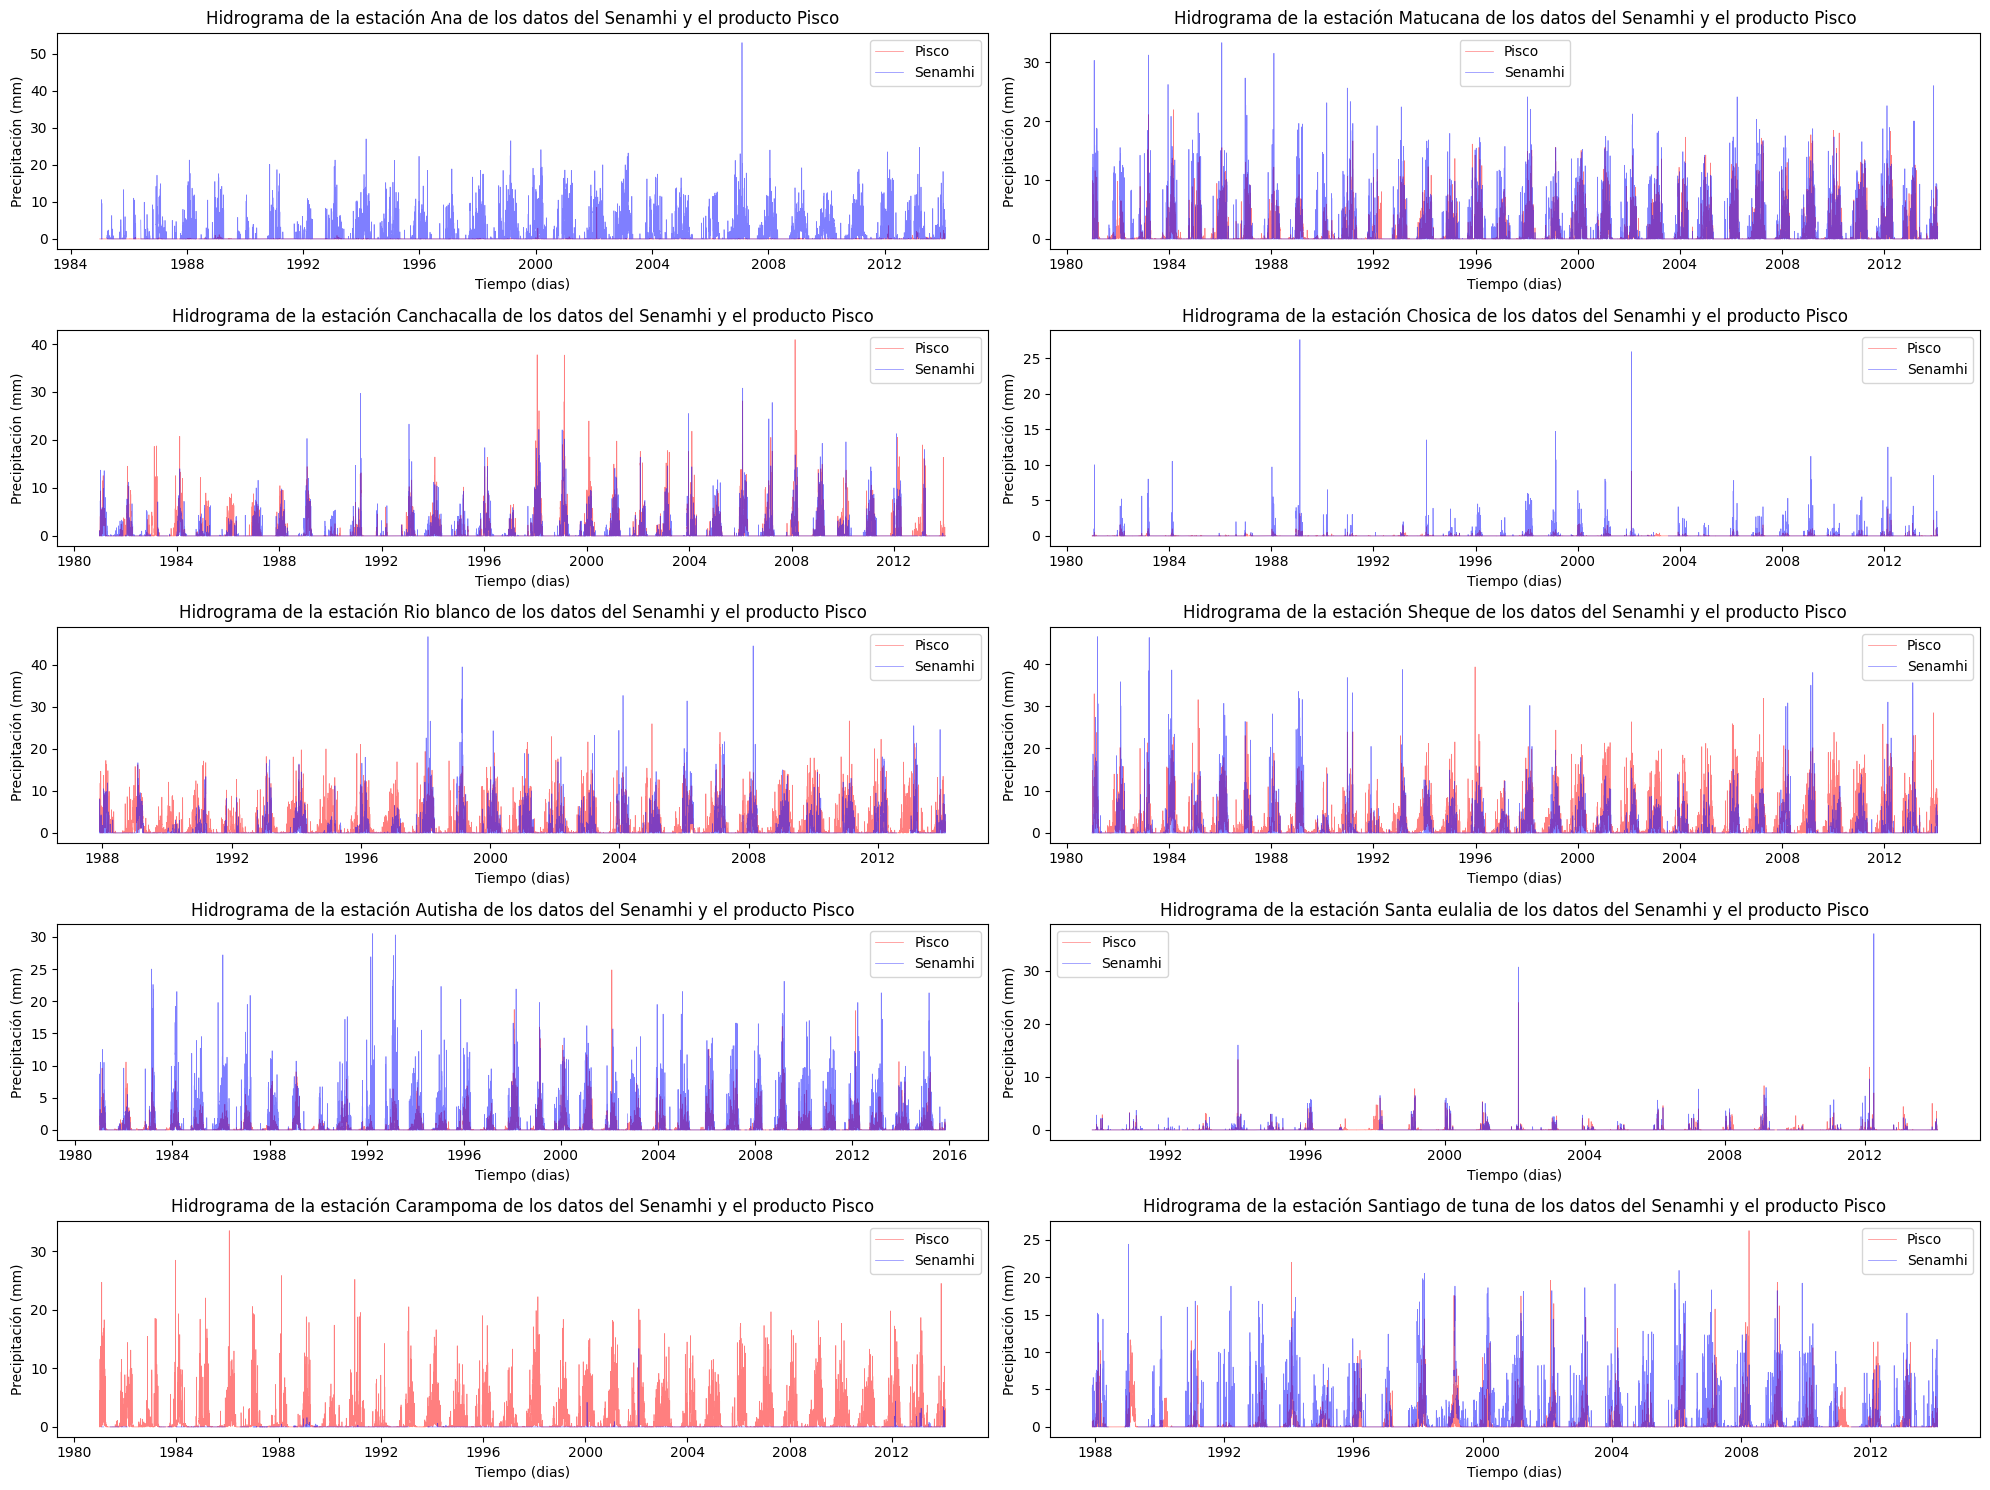

In [13]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (20, 15))

axes = axes.flatten()

for i, col in enumerate(estaciones_nom):
    
    df_pisco = nc_to_df("pp_daily.nc", longitud[i], latitud[i])

    df_senamhi = txt_to_df(list_pp[i])
    
    range_min = max(df_pisco.index.min(), df_senamhi.index.min())

    range_max = min(df_pisco.index.max(), df_senamhi.index.max())

    pisco = df_pisco[range_min: range_max]

    senamhi = df_senamhi[range_min: range_max]
    
    axes[i].plot(pisco.index, pisco.precipitation, "r-", alpha = 0.5, lw = 0.5, label = "Pisco")
    
    axes[i].plot(senamhi.index, senamhi.precipitation, "b-", alpha = 0.5, lw = 0.5, label = "Senamhi")
    
    axes[i].set_title(f"Hidrograma de la estación {col.capitalize()} de los datos del Senamhi y el producto Pisco")
    
    axes[i].set_xlabel("Tiempo (dias)")
    
    axes[i].set_ylabel("Precipitación (mm)")
    
    axes[i].legend()
    
plt.tight_layout()


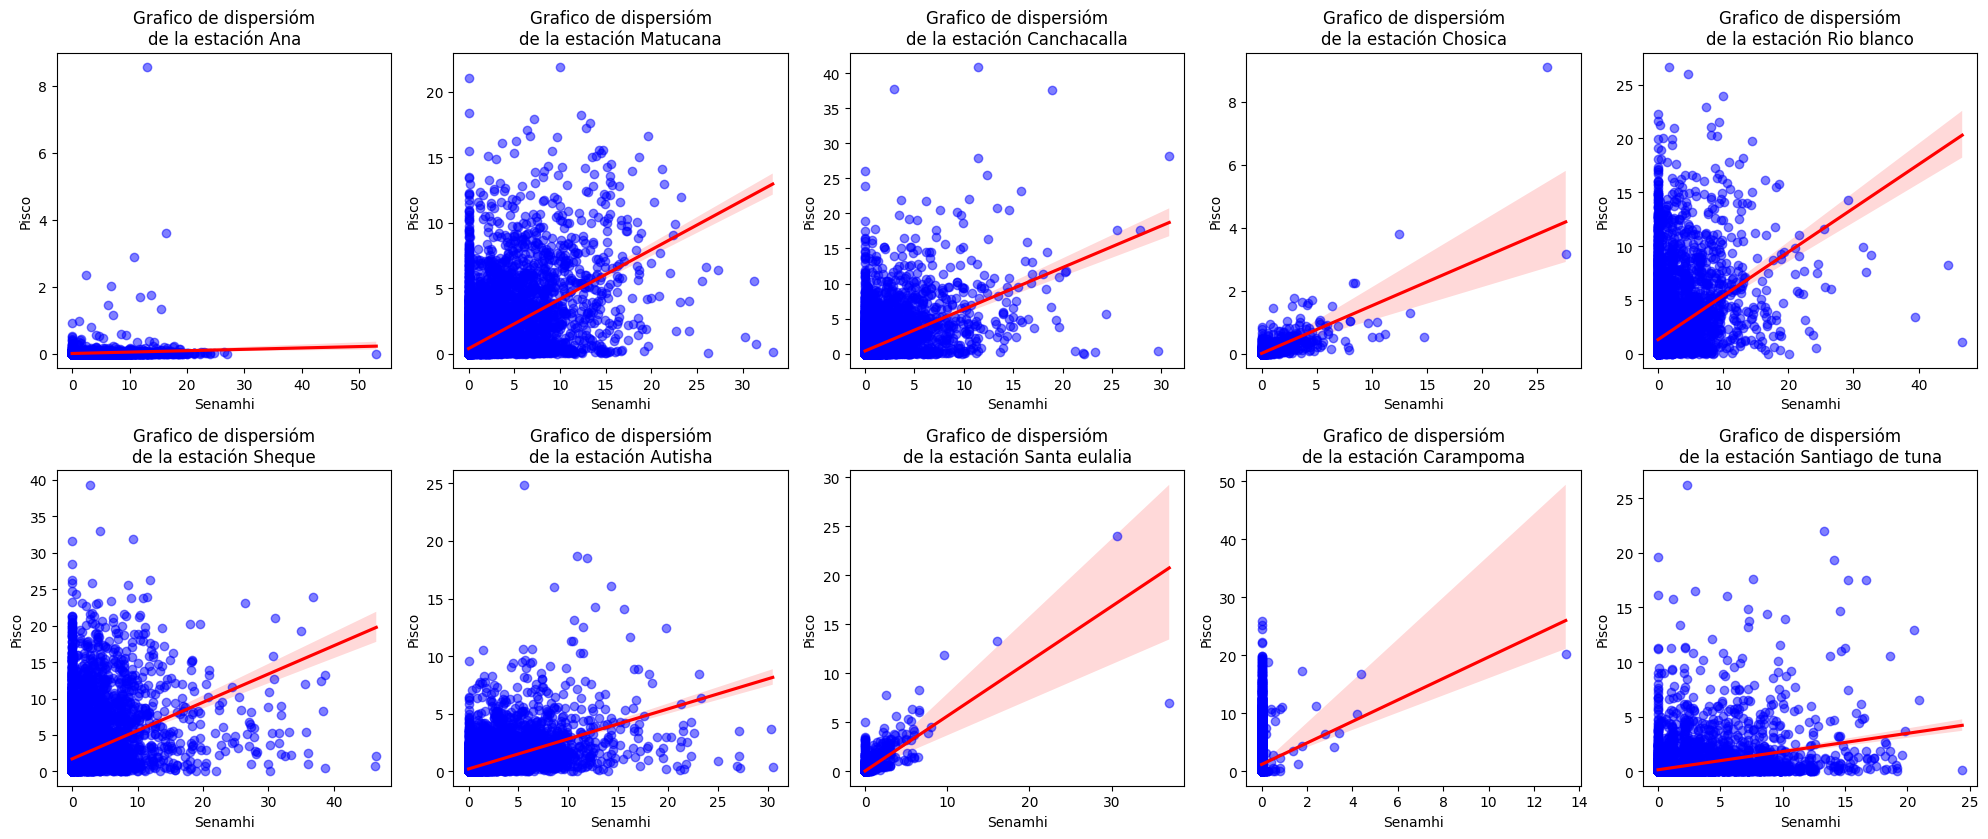

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 8.5))

axes = axes.flatten()

for i, col in enumerate(estaciones_nom):
    
    df_pisco = nc_to_df("pp_daily.nc", longitud[i], latitud[i])

    df_senamhi = txt_to_df(list_pp[i])
    
    range_min = max(df_pisco.index.min(), df_senamhi.index.min())

    range_max = min(df_pisco.index.max(), df_senamhi.index.max())

    pisco = df_pisco[range_min: range_max]

    senamhi = df_senamhi[range_min: range_max]
        
    axes[i].plot(senamhi.precipitation, pisco.precipitation, "bo", alpha = 0.5)
    
    sns.regplot(x = senamhi, y = pisco, ax = axes[i], scatter = False, color = 'r')
    
    axes[i].set_title(f"Grafico de dispersióm\nde la estación {col.capitalize()}")
    
    axes[i].set_xlabel("Senamhi")
    
    axes[i].set_ylabel("Pisco")
    
plt.tight_layout()

# Metricas

In [15]:
metricas = metrics(estaciones_nom)
metricas

,c.datos,%faltante,pbias,nse,rmse
ANA,10623,3.34,99.345646,-0.192571,3.471625
MATUCANA,12084,1.27,29.569277,0.266040,2.554748
CANCHACALLA,12053,2.46,-27.242533,-0.183093,2.070222
CHOSICA,12084,2.77,77.083964,0.255427,0.558345
RIO BLANCO,9559,1.92,-97.206407,-0.519213,3.300729
SHEQUE,12084,2.35,-125.613438,-0.675750,4.136438
AUTISHA,12722,3.40,48.814294,0.276287,2.055707
SANTA EULALIA,8828,5.10,-20.491304,0.600508,0.443303
CARAMPOMA,12084,13.30,-23240.769336,-325.508369,2.898934
SANTIAGO DE TUNA,9559,6.33,71.167943,-0.010518,2.731197


In [16]:
metricas.sort_values(by = "nse", ascending = False)

,c.datos,%faltante,pbias,nse,rmse
SANTA EULALIA,8828,5.10,-20.491304,0.600508,0.443303
AUTISHA,12722,3.40,48.814294,0.276287,2.055707
MATUCANA,12084,1.27,29.569277,0.266040,2.554748
CHOSICA,12084,2.77,77.083964,0.255427,0.558345
SANTIAGO DE TUNA,9559,6.33,71.167943,-0.010518,2.731197
CANCHACALLA,12053,2.46,-27.242533,-0.183093,2.070222
ANA,10623,3.34,99.345646,-0.192571,3.471625
RIO BLANCO,9559,1.92,-97.206407,-0.519213,3.300729
SHEQUE,12084,2.35,-125.613438,-0.675750,4.136438
CARAMPOMA,12084,13.30,-23240.769336,-325.508369,2.898934


# Completación de datos faltantes

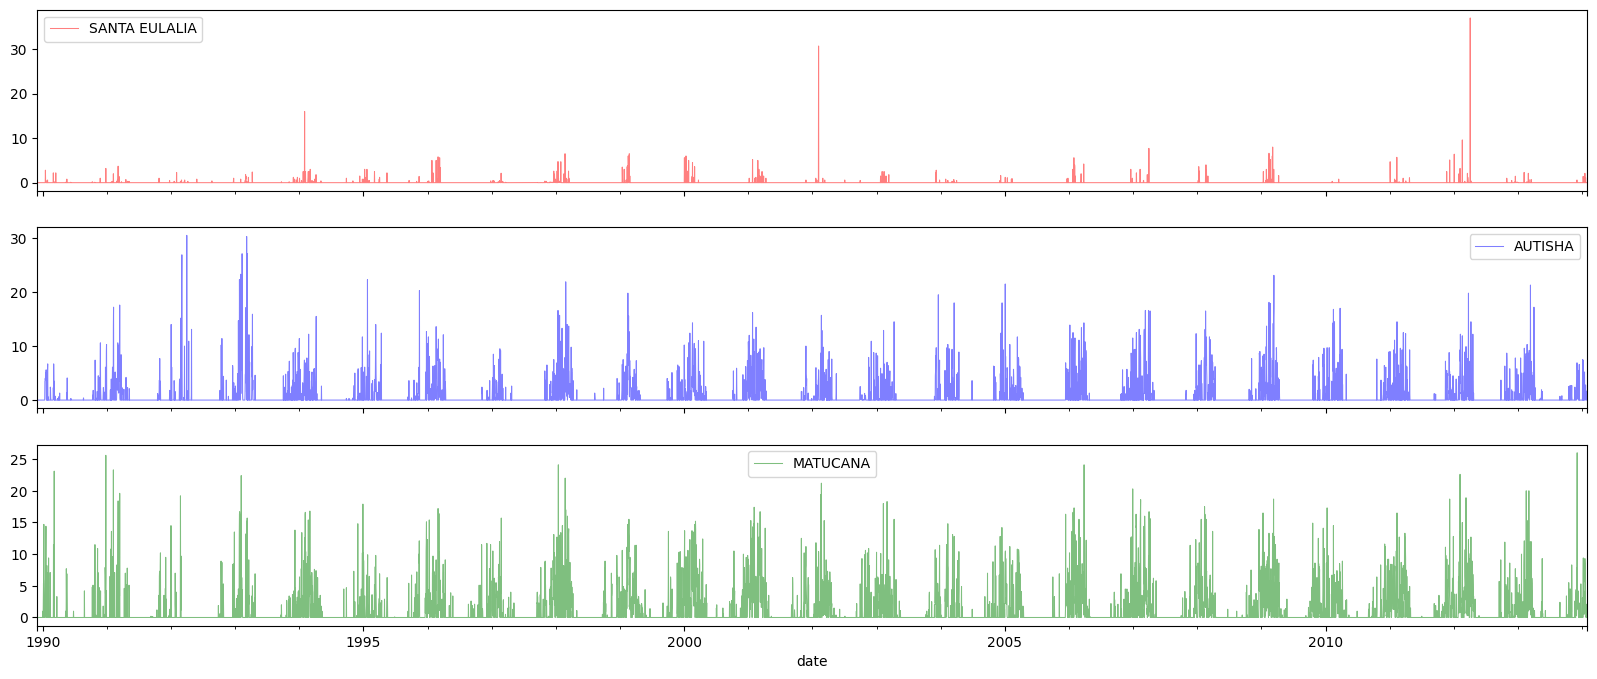

In [17]:
fill_station("SANTA EULALIA", "AUTISHA", "MATUCANA").plot(
    figsize = (20, 8), alpha = 0.5, lw = 0.75, color = ["red", "blue", "green"], subplots = True);

**CONCLUSIÓN:** Se considera que la estación Santa Eulalia, cuenta con valores semejantes a el producto Pisco observados según las metricas, y por tanto se podría hacer uso en el completado de datos. También se considera que se esta trabajando con datos diarios, y al ser así presenta mayor variabidad que trabajar con datos con mensuales o anuales, ya que estan tienen una tendencia estacional estacional en el año. Finalmente se realiza un supuesto reemplazo, pero esto es ficticio, solo para un explicación academica.